In [1]:
#Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import re

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
from wordcloud import WordCloud

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, precision_score
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import MultinomialNB

In [2]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/EL_Cyberbullying/cyberbullying_tweets.csv")
df.head()

,tweet_text,cyberbullying_type
0,"In other words #katandandre, your food was cra...",not_cyberbullying
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying


### Exploratory analysis

In [6]:
df.describe()

,tweet_text,cyberbullying_type
count,47692,47692
unique,46017,6
top,RT @sailorhg: the intro for my hardware hackin...,religion
freq,2,7998


In [7]:
#Remove duplicates per row
df.drop_duplicates(inplace=True)
df.describe()

,tweet_text,cyberbullying_type
count,47656,47656
unique,46017,6
top,@sschinke @Blackamazon @shanley also sorta wor...,religion
freq,2,7997


In [8]:
pd.set_option('display.max_colwidth', None)
df_groupby_tweet=df.groupby('tweet_text').count().sort_values(by='cyberbullying_type', ascending=False).reset_index()
df_groupby_tweet[df_groupby_tweet['cyberbullying_type']>1]

,tweet_text,cyberbullying_type
0,What a riveting little lesson in walking the catwalk. Thanks ladies #MKR,2
1,"@KaitlynBurnell to be clear, i'm not bringing this up to defend bri. i'm aware that she's fully capable of defending herself.",2
2,@NedGilmore oh! go get meat from south.,2
3,@kate_1985 - not sure!! But never fear @mykitchenrules still has 751 teams left and another Instant Restaurant round to come. #MKR,2
4,@NetTxt doesn't work that way. Sorry to disappoint you. No one cares what you want.,2
...,...,...
1634,RT @HelpIamaCabbage: @freebsdgirl People are spending money to try to get you temporarily suspended from twitter? That may be the most was…,2
1635,TODO: email tax guy to ask if lavender bath bombs qualify as a business expense.,2
1636,"Yes, we get it. You're pretty. Tone down the self promo and just cook! @mykitchenrules #MKR",2
1637,"RT @DustyPee: If #cuntandandre make it through, I'll... I don't know what I will do. #mkr",2


In [9]:
df[df['tweet_text']=="Yes, we get it. You're pretty. Tone down the self promo and just cook! @mykitchenrules #MKR"]

,tweet_text,cyberbullying_type
9109,"Yes, we get it. You're pretty. Tone down the self promo and just cook! @mykitchenrules #MKR",gender
28463,"Yes, we get it. You're pretty. Tone down the self promo and just cook! @mykitchenrules #MKR",other_cyberbullying


In [10]:
df[df['tweet_text']=="@KaitlynBurnell to be clear, i'm not bringing this up to defend bri. i'm aware that she's fully capable of defending herself."]

,tweet_text,cyberbullying_type
6686,"@KaitlynBurnell to be clear, i'm not bringing this up to defend bri. i'm aware that she's fully capable of defending herself.",not_cyberbullying
29619,"@KaitlynBurnell to be clear, i'm not bringing this up to defend bri. i'm aware that she's fully capable of defending herself.",other_cyberbullying


In [11]:
#Remove duplicates based on tweet text. Keep only on cyberullying type per tweet
df.drop_duplicates(subset='tweet_text', keep="first", inplace=True)
df.describe()

,tweet_text,cyberbullying_type
count,46017,46017
unique,46017,6
top,"In other words #katandandre, your food was crapilicious! #mkr",religion
freq,1,7995


In [12]:
#Number of tweets per type of cyberbullying (after removing duplicates)
df.groupby('cyberbullying_type').count()

,tweet_text
cyberbullying_type,
age,7992
ethnicity,7952
gender,7898
not_cyberbullying,7937
other_cyberbullying,6243
religion,7995


### Preprocess tweets

In [13]:
stemmer = SnowballStemmer("english")
stemmer.stem("studies")

'studi'

In [14]:
lematizer=WordNetLemmatizer()
lematizer.lemmatize("studies")

'study'

In [15]:
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")
lematizer=WordNetLemmatizer()

def preprocess_tweet(tweet, stem=False):
    #Remove special caracters, links and user tags
    regexp_pattern="@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"
    tweet = re.sub(regexp_pattern, ' ', str(tweet).lower()).strip()
    #Remove stopwords
    tweet=" ".join([word for word in str(tweet).split() if word not in stop_words])
    #Stemming: Removes suffixes and prefixes. Ex. studies->studi.
    if stem==True:
        tweet= " ".join([stemmer.stem(word) for word in tweet.split()])
    #Lemmatizing: Gets the root word (better). studies->study
    tweet=" ".join([lematizer.lemmatize(word) for word in tweet.split()])
    return tweet

In [16]:
#Preprocess tweets
df['tweet_cleaned']=df['tweet_text'].apply(preprocess_tweet)
df.head()

,tweet_text,cyberbullying_type,tweet_cleaned
0,"In other words #katandandre, your food was crapilicious! #mkr",not_cyberbullying,word katandandre food crapilicious mkr
1,Why is #aussietv so white? #MKR #theblock #ImACelebrityAU #today #sunrise #studio10 #Neighbours #WonderlandTen #etc,not_cyberbullying,aussietv white mkr theblock imacelebrityau today sunrise studio10 neighbour wonderlandten etc
2,@XochitlSuckkks a classy whore? Or more red velvet cupcakes?,not_cyberbullying,classy whore red velvet cupcake
3,"@Jason_Gio meh. :P thanks for the heads up, but not too concerned about another angry dude on twitter.",not_cyberbullying,meh p thanks head concerned another angry dude twitter
4,"@RudhoeEnglish This is an ISIS account pretending to be a Kurdish account. Like Islam, it is all lies.",not_cyberbullying,isi account pretending kurdish account like islam lie


In [17]:
df.describe()

,tweet_text,cyberbullying_type,tweet_cleaned
count,46017,46017,46017
unique,46017,6,44942
top,"In other words #katandandre, your food was crapilicious! #mkr",religion,
freq,1,7995,271


In [18]:
df.groupby('tweet_cleaned').count().sort_values(by='cyberbullying_type', ascending=False).reset_index()

,tweet_cleaned,tweet_text,cyberbullying_type
0,,271,271
1,fuck dumb nigger,45,45
2,bully,36,36
3,yes,25,25
4,feminazi,24,24
...,...,...,...
44937,halalflaws biebervalue greenlinerzjm bitch copied hadith go look hadith bitch,1,1
44938,halalflaws biebervalue greenlinerzjm go look word taquiyya,1,1
44939,halalflaws biebervalue greenlinerzjm islamic culture islamic religion,1,1
44940,halalflaws biebervalue muslim woman treated like queen,1,1


In [19]:
#Remove empty tweets
df.dropna(subset = ["tweet_cleaned"], inplace=True)

In [20]:
df[df['tweet_cleaned']=='feminazi']
#Should be remove duplicates after cleaning tweet?

,tweet_text,cyberbullying_type,tweet_cleaned
8222,@piojaa_ feminazi,gender,feminazi
8503,@Bourgholtzer feminazi,gender,feminazi
9765,FEMINAZI,gender,feminazi
9791,'Feminazi' http://t.co/Y5skW0daNu,gender,feminazi
10138,@Fernandarova feminazi,gender,feminazi
11378,@FunkAd3 feminazi.,gender,feminazi
12134,To feminazi,gender,feminazi
12181,Feminazi (?),gender,feminazi
12385,Feminazi.,gender,feminazi
12817,Feminazi 😳,gender,feminazi


### Word cloud and common words count

Type of cyberbullying: not_cyberbullying


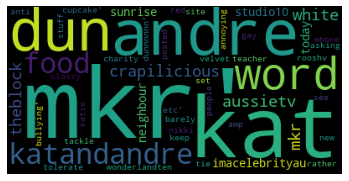


Type of cyberbullying: gender


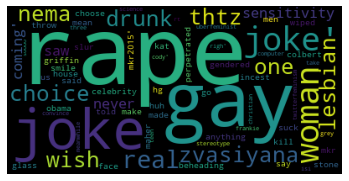


Type of cyberbullying: religion


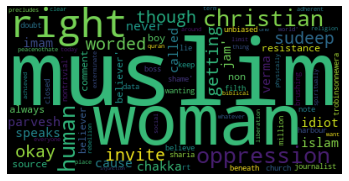


Type of cyberbullying: other_cyberbullying


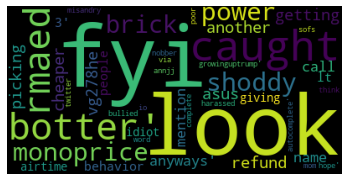


Type of cyberbullying: age


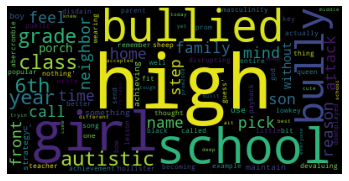


Type of cyberbullying: ethnicity


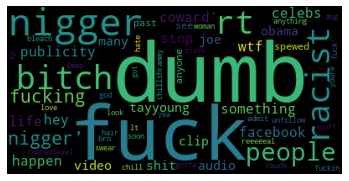

In [21]:
for i in df['cyberbullying_type'].unique():
  #Filter the tweets for each type
  tweets_type=df[df['cyberbullying_type']==i]
  tweets = tweets_type['tweet_cleaned'].values 
  #Generate wordcloud
  wordcloud = WordCloud().generate(str(tweets))
  print("Type of cyberbullying:", i)
  #Display word cloud
  plt.imshow(wordcloud)
  plt.axis("off")
  plt.show()
  print("")

Type of cyberbullying: not_cyberbullying
       word  count
0       mkr   1612
1        rt    794
2  bullying    725
3     bully    423
4      like    408
5    school    380
6       get    354
7       kat    300
8       amp    283
9    people    274


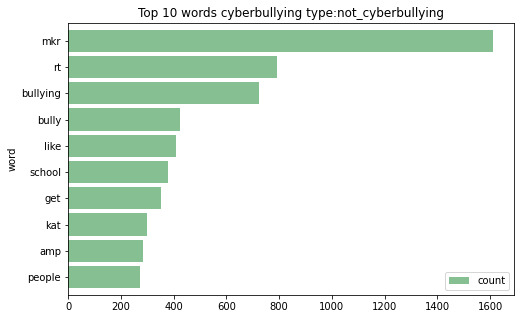


Type of cyberbullying: gender
     word  count
0    joke   5376
1    rape   4304
2     gay   4195
3      rt   1241
4   woman   1211
5   bitch   1174
6  female   1132
7    call   1115
8  people   1010
9  sexist    982


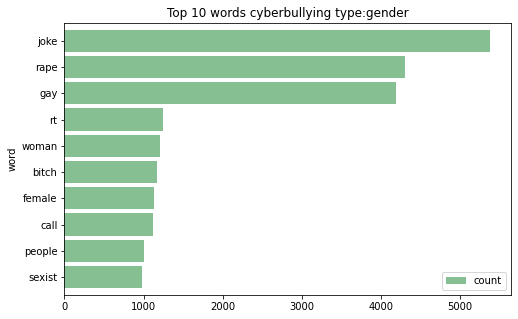


Type of cyberbullying: religion
        word  count
0     muslim   4868
1      idiot   3122
2  christian   2142
3          u   2030
4  terrorist   1466
5      right   1342
6    islamic   1285
7      woman   1278
8       like   1252
9      islam   1240


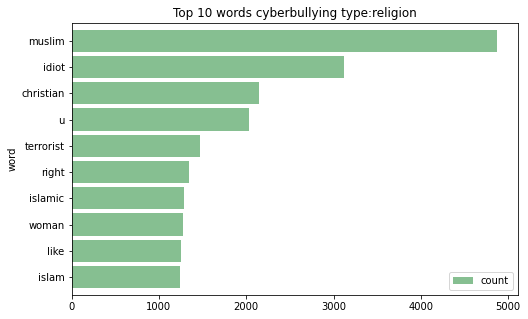


Type of cyberbullying: other_cyberbullying
      word  count
0       rt    750
1    bully    564
2     like    410
3  fucking    364
4   people    354
5      get    306
6    idiot    268
7     know    236
8        u    233
9    think    221


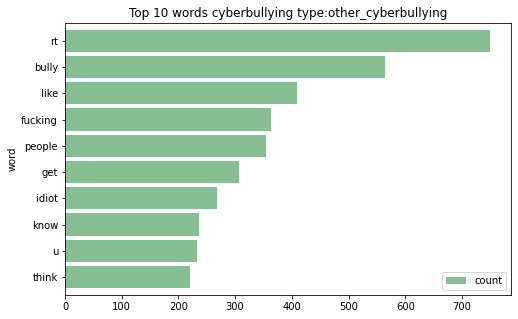


Type of cyberbullying: age
      word  count
0   school   8645
1     high   5089
2     girl   4699
3    bully   4403
4  bullied   4393
5     like   1896
6      one   1052
7   people    936
8      got    827
9      kid    816


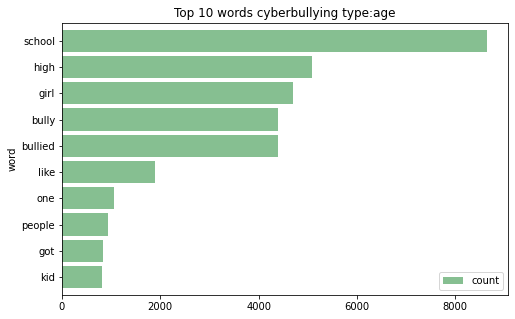


Type of cyberbullying: ethnicity
     word  count
0  nigger   5798
1    fuck   5489
2    dumb   5215
3      as   2281
4   black   2203
5       u   2167
6   white   1604
7      rt   1221
8  people   1192
9   obama   1145


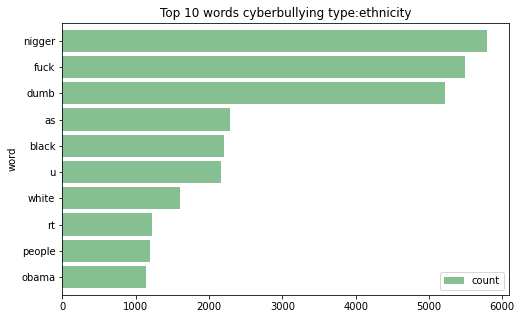

In [22]:
for i in df['cyberbullying_type'].unique():
  #Filter the tweets for each type
  tweets_type=df[df['cyberbullying_type']==i]
  tweets = tweets_type['tweet_cleaned'].values 
  print("Type of cyberbullying:", i)
  #Count frequency for each word and get top 10
  top_words=Counter(" ".join(df["tweet_cleaned"][df['cyberbullying_type']==i]).split()).most_common(10)
  top_words_df=pd.DataFrame(top_words, columns=['word', 'count'])
  print(top_words_df)
  top_words_df=top_words_df.sort_values('count',ascending=True)
  #Make horizontal bar plot to display top 10 words and their frequency
  top_words_df.plot.barh(x='word', y='count', figsize=(8, 5), title="Top 10 words cyberbullying type:"+i, color='#86bf91', zorder=2, width=0.85)
  plt.show()
  print("")

### Feature engineering

In [23]:
#Assign ids to each cyberbullying type
types=df['cyberbullying_type'].unique()
types_ids=[0,1,2,3,4,5]
df_cyber_types=pd.DataFrame(list(zip(types, types_ids)),
               columns =['cyberbullying_type', 'cyberbullying_id'])
df_cyber_types

,cyberbullying_type,cyberbullying_id
0,not_cyberbullying,0
1,gender,1
2,religion,2
3,other_cyberbullying,3
4,age,4
5,ethnicity,5


In [24]:
#Add cyberbullying ids to the full data
df=pd.merge(df, df_cyber_types, how='left', on='cyberbullying_type')
df.head()

,tweet_text,cyberbullying_type,tweet_cleaned,cyberbullying_id
0,"In other words #katandandre, your food was crapilicious! #mkr",not_cyberbullying,word katandandre food crapilicious mkr,0
1,Why is #aussietv so white? #MKR #theblock #ImACelebrityAU #today #sunrise #studio10 #Neighbours #WonderlandTen #etc,not_cyberbullying,aussietv white mkr theblock imacelebrityau today sunrise studio10 neighbour wonderlandten etc,0
2,@XochitlSuckkks a classy whore? Or more red velvet cupcakes?,not_cyberbullying,classy whore red velvet cupcake,0
3,"@Jason_Gio meh. :P thanks for the heads up, but not too concerned about another angry dude on twitter.",not_cyberbullying,meh p thanks head concerned another angry dude twitter,0
4,"@RudhoeEnglish This is an ISIS account pretending to be a Kurdish account. Like Islam, it is all lies.",not_cyberbullying,isi account pretending kurdish account like islam lie,0


In [25]:
#Get the length of the tweet: number of words
df['nwords']=(df['tweet_cleaned'].str.split()).apply(len)
#get number of letters
df['nletters']=(df['tweet_cleaned']).apply(len)
#get number of vowels
df['nvowels']=df['tweet_cleaned'].str.count(r'[aeiou]')
df.head()

,tweet_text,cyberbullying_type,tweet_cleaned,cyberbullying_id,nwords,nletters,nvowels
0,"In other words #katandandre, your food was crapilicious! #mkr",not_cyberbullying,word katandandre food crapilicious mkr,0,5,38,13
1,Why is #aussietv so white? #MKR #theblock #ImACelebrityAU #today #sunrise #studio10 #Neighbours #WonderlandTen #etc,not_cyberbullying,aussietv white mkr theblock imacelebrityau today sunrise studio10 neighbour wonderlandten etc,0,11,93,32
2,@XochitlSuckkks a classy whore? Or more red velvet cupcakes?,not_cyberbullying,classy whore red velvet cupcake,0,5,31,9
3,"@Jason_Gio meh. :P thanks for the heads up, but not too concerned about another angry dude on twitter.",not_cyberbullying,meh p thanks head concerned another angry dude twitter,0,9,54,15
4,"@RudhoeEnglish This is an ISIS account pretending to be a Kurdish account. Like Islam, it is all lies.",not_cyberbullying,isi account pretending kurdish account like islam lie,0,8,53,19


In [26]:
#Describe features for each cyberbullying type
df_features=df[['cyberbullying_type', 'nwords','nletters', 'nvowels']].groupby('cyberbullying_type').median().sort_values(by='nwords')
df_features

,nwords,nletters,nvowels
cyberbullying_type,,,
other_cyberbullying,7.0,46.0,14.0
not_cyberbullying,8.0,48.0,15.0
gender,12.0,78.0,24.0
ethnicity,14.0,81.0,24.0
age,16.0,103.0,31.0
religion,19.0,129.0,42.0


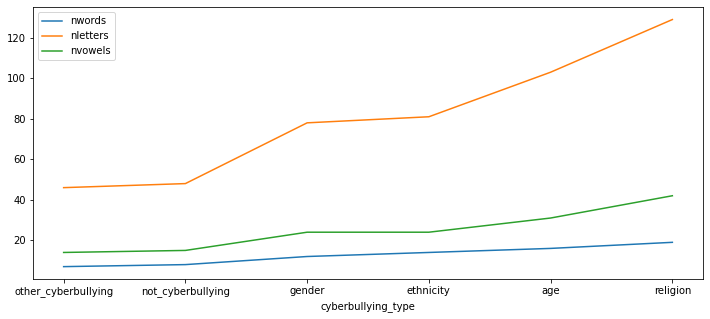

In [27]:
#Plot features
df_features.plot(figsize=(12, 5))

In [28]:
#Train/test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(np.array(df["tweet_cleaned"]),np.array(df["cyberbullying_id"]), test_size=0.25, random_state=0)
print(X_train.shape)
print(X_test.shape)

(34512,)
(11505,)


In [29]:
#TF_IDF Matrix
#initialise the vectorizer and then call fit and transform over it to calculate the TF-IDF score for the text
tf_idf = TfidfVectorizer(use_idf=True, min_df=0.00002, max_df=0.6)
tf_idf_train_features = tf_idf.fit_transform(X_train.astype('U'))

tf_idf_test_features = tf_idf.transform(X_test.astype('U'))

print('TFIDF: Train features shape:', tf_idf_train_features.shape, ' Test features shape:', tf_idf_test_features.shape)

TFIDF: Train features shape: (34512, 38972)  Test features shape: (11505, 38972)


In [30]:
#the tuple represents sentence number and feature (word) number. The value in front is the tf-idf weight
#TF-IDF weights words based on relevance, one can use this technique to determine that the words with the highest relevance are the most important
print(tf_idf_train_features)

  (0, 5553)	0.22339583127720647
  (0, 30447)	0.18958712770009828
  (0, 15822)	0.22306478374748634
  (0, 25036)	0.2507060367376909
  (0, 23065)	0.6838702627215364
  (0, 17931)	0.5778071241673438
  (1, 34781)	0.290587471926034
  (1, 16850)	0.5080897206076608
  (1, 4504)	0.314762414785228
  (1, 14138)	0.1861806975306866
  (1, 3265)	0.28830387310697764
  (1, 37356)	0.3379618668917561
  (1, 20129)	0.38345524543747705
  (1, 26145)	0.16743614649646302
  (1, 21045)	0.38891514749296974
  (2, 37620)	0.3030302002599279
  (2, 20480)	0.156387856416554
  (2, 33191)	0.304261848842469
  (2, 12457)	0.3927506648022063
  (2, 29762)	0.17132528281338977
  (2, 28225)	0.4285025176788185
  (2, 3396)	0.23542482467941112
  (2, 13128)	0.6070383599647927
  (3, 25839)	0.25554992643026875
  (3, 38304)	0.22658933449838742
  :	:
  (34510, 18731)	0.24990612414853947
  (34510, 13206)	0.23598041421316748
  (34510, 33889)	0.201954702890267
  (34510, 26637)	0.21332668784418243
  (34510, 16975)	0.19758852455020925
  (34510

In [31]:
#Get the list of features names (in our case, features are words) and their index
feature_names={}
for i, feature in enumerate(tf_idf.get_feature_names_out()):
    feature_names[i]= feature
    if i>=23050 and i<=23070:
      print(i, feature_names[i])

23050 morley
23051 mormon
23052 morn
23053 morneau
23054 morning
23055 morninggloria
23056 morningjoe
23057 moro
23058 moroccan
23059 morocco
23060 moromon
23061 moron
23062 moronic
23063 moronity
23064 morph
23065 morphed
23066 morphs
23067 morra
23068 morris17
23069 morrison
23070 mortais


In [ ]:
# feature_array = np.array(tf_idf.get_feature_names_out())
# tfidf_sorted = np.argsort(tf_idf_train_features.toarray()).flatten()[::-1]
# n = 10
# top_n = feature_array[tfidf_sorted][:n]

### Modelling

In [34]:
#Define classifiers
clfs = {
    "Decision Tree":DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Gradient Boosting":GradientBoostingClassifier(random_state=42),
    "XGBoost": XGBClassifier(eval_metric="mlogloss",random_state=42),
    "AdaBoost": AdaBoostClassifier(random_state=42),
    "LightGBM": LGBMClassifier(random_state=42) #Light Gradient Boosting Machine: usually faster than xgboost   
}

#Fitting function
def fit_model(clf,x_train,y_train,x_test, y_test):
    clf.fit(x_train,y_train)
    y_pred = clf.predict(x_test)
    accuracy = accuracy_score(y_pred, y_test)
    return accuracy

accuracies = []

#Fit models and save accuracies
for name,clf in clfs.items():
    curr_acc = fit_model(clf,tf_idf_train_features,y_train,tf_idf_test_features,y_test)
    accuracies.append(curr_acc)

In [35]:
#Print and compare performance for all models
models_accuracy_df = pd.DataFrame({"Models":clfs.keys(),"Accuracy Scores":accuracies}).sort_values('Accuracy Scores',ascending=False)
models_accuracy_df

,Models,Accuracy Scores
1,Random Forest,0.848761
5,LightGBM,0.845980
2,Gradient Boosting,0.837636
0,Decision Tree,0.828509
3,XGBoost,0.828075
4,AdaBoost,0.795567
